In [4]:
import numpy as np
import pandas as pd
# import geopy

from gensim import corpora, models, similarities
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
import string
import math
from pprint import pprint
from collections import defaultdict

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./sample_data_2017_FINAL.csv')

In [6]:
df['text'] = df['ActivityOrMissionDesc'] + ' ' + df['Desc']

In [8]:
df = df[~df['text'].isna()]

## Functions for model training

In [20]:
def create_corpus(df):
    
    documents = list(df['text'].values)
    stop_words = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer(r'\w+')

    texts = [[word for word in tokenizer.tokenize(document.lower()) if word not in stop_words] for document in documents]
    texts = [[word for word in text if not word.isnumeric()] for text in texts]

    # remove words that appear only once in corpus
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1

    texts = [[token for token in text if frequency[token] > 1]
             for text in texts]

    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    
    return corpus_tfidf, dictionary

In [29]:
def train_model(corpus, dictionary, num_topics):
    
    model_LSI = models.LsiModel(corpus, id2word=dictionary, num_topics=num_topics) # initialize an LSI transformation
#     model_LSI.print_topics(num_topics)

    return model_LSI

In [14]:
def transform_corpus(model, corpus, num_topics):
    
    corpus_LSI = model[corpus]
    corpus_list = []
    
    for c in corpus_LSI:
        scores = []
        for i in range(len(c)):
            scores.append(c[i][1])
        if len(scores) == num_topics:
            corpus_list.append(np.array(scores))
        else:
            corpus_list.append(np.zeros(num_topics))    
    corpus_LSI = np.array(corpus_list)
    
    return corpus_LSI

In [15]:
def plot_elbow(corpus_LSI, k_max, num_topics):
    distortions = []
    K = range(1,k_max)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, init = 'k-means++', random_state = 0).fit(corpus_LSI)
        distortions.append(sum(np.min(cdist(corpus_LSI, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / corpus_LSI.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'x')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('num_topics = ' + str(num_topics))
    plt.show()

In [30]:
# num_topics = 3
k_max = 50

def lsi_model(corpus, dictionary, num_topics):
#     corpus, dictionary = create_corpus(df)
    model = train_model(corpus, dictionary, num_topics)
    corpus_LSI = transform_corpus(model, corpus, num_topics)
    plot_elbow(corpus_LSI, k_max, num_topics)
    print(model.print_topics())
    return model, corpus_LSI

In [43]:
# num_topics = 3
# num_clusters = 7

def final_model(corpus, dictionary, num_topics, num_clusters):
    m, c = lsi_model(corpus, dictionary, num_topics)
    kmeans = KMeans(n_clusters = num_clusters, init = 'k-means++', random_state = 0).fit(c)
    print(np.unique(kmeans.labels_, return_counts=True))
    c = pd.DataFrame(c)
    df['labels'] = kmeans.labels_
    df = pd.concat([df.reset_index(drop = True), c], axis = 1)
    return m, df

## Try different number of topics

In [24]:
corpus, dictionary = create_corpus(df)

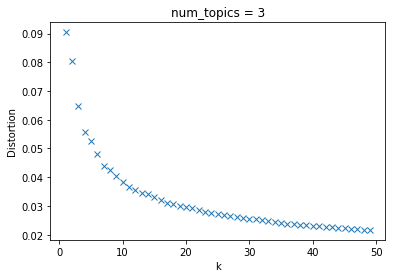

[(0, '0.201*"services" + 0.188*"care" + 0.161*"children" + 0.161*"health" + 0.148*"community" + 0.148*"school" + 0.143*"provide" + 0.140*"housing" + 0.130*"education" + 0.125*"programs"'), (1, '-0.513*"housing" + -0.371*"low" + -0.355*"income" + -0.238*"elderly" + -0.171*"persons" + -0.165*"affordable" + 0.156*"school" + -0.145*"moderate" + 0.130*"students" + -0.113*"hud"'), (2, '-0.394*"care" + 0.323*"school" + -0.294*"health" + 0.261*"students" + -0.194*"services" + 0.186*"housing" + 0.157*"low" + -0.157*"medical" + 0.149*"income" + 0.136*"charter"')]


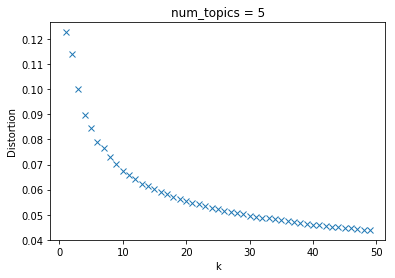

[(0, '0.198*"services" + 0.184*"care" + 0.162*"children" + 0.157*"health" + 0.151*"school" + 0.149*"community" + 0.143*"provide" + 0.141*"housing" + 0.131*"education" + 0.126*"programs"'), (1, '-0.515*"housing" + -0.371*"low" + -0.355*"income" + -0.240*"elderly" + -0.172*"persons" + 0.167*"school" + -0.166*"affordable" + -0.146*"moderate" + 0.136*"students" + -0.114*"hud"'), (2, '-0.423*"care" + -0.306*"health" + 0.246*"school" + 0.225*"students" + -0.217*"services" + 0.187*"housing" + -0.160*"medical" + 0.155*"low" + 0.147*"income" + -0.127*"home"'), (3, '0.391*"members" + -0.362*"school" + -0.273*"children" + -0.201*"students" + 0.142*"club" + 0.140*"union" + 0.136*"business" + 0.132*"industry" + 0.123*"promote" + -0.119*"charter"'), (4, '-0.302*"see" + -0.297*"schedule" + 0.276*"club" + 0.242*"children" + 0.210*"members" + 0.200*"youth" + 0.174*"golf" + -0.172*"health" + 0.164*"social" + 0.151*"recreational"')]


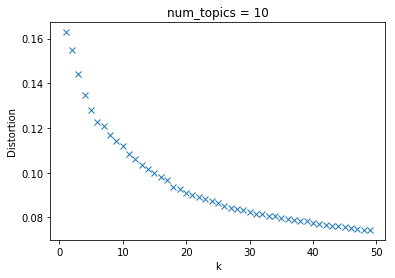

[(0, '0.198*"services" + 0.187*"care" + 0.163*"children" + 0.158*"health" + 0.152*"school" + 0.148*"community" + 0.143*"provide" + 0.141*"housing" + 0.131*"education" + 0.126*"programs"'), (1, '-0.507*"housing" + -0.364*"low" + -0.348*"income" + -0.233*"elderly" + 0.195*"school" + -0.168*"persons" + -0.164*"affordable" + 0.158*"students" + -0.142*"moderate" + -0.110*"hud"'), (2, '-0.374*"care" + 0.316*"school" + -0.311*"health" + 0.261*"students" + -0.212*"services" + 0.206*"housing" + 0.176*"low" + 0.167*"income" + -0.159*"medical" + -0.113*"hospital"'), (3, '0.380*"members" + -0.318*"school" + -0.260*"children" + -0.203*"care" + -0.187*"students" + 0.160*"club" + 0.157*"business" + 0.140*"industry" + 0.139*"promote" + -0.123*"child"'), (4, '0.298*"youth" + 0.273*"children" + -0.215*"health" + -0.201*"students" + -0.186*"care" + 0.169*"soccer" + 0.154*"families" + -0.153*"school" + 0.150*"club" + 0.134*"disabilities"'), (5, '-0.372*"club" + -0.304*"members" + -0.236*"golf" + -0.189*"c

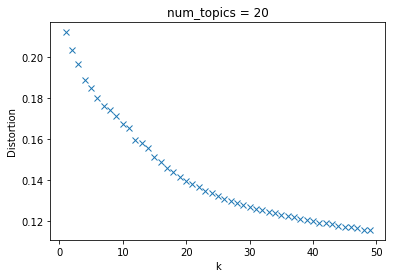

[(0, '0.199*"services" + 0.187*"care" + 0.162*"children" + 0.158*"health" + 0.153*"school" + 0.148*"community" + 0.144*"provide" + 0.140*"housing" + 0.131*"education" + 0.126*"programs"'), (1, '-0.506*"housing" + -0.362*"low" + -0.347*"income" + -0.234*"elderly" + 0.198*"school" + -0.168*"persons" + -0.163*"affordable" + 0.161*"students" + -0.142*"moderate" + -0.110*"hud"'), (2, '-0.373*"care" + 0.322*"school" + -0.299*"health" + 0.271*"students" + 0.210*"housing" + -0.210*"services" + 0.180*"low" + 0.170*"income" + -0.155*"medical" + -0.114*"home"'), (3, '0.377*"members" + -0.319*"school" + -0.255*"children" + -0.214*"care" + -0.187*"students" + 0.163*"club" + 0.149*"business" + 0.138*"promote" + 0.132*"industry" + -0.124*"child"'), (4, '0.285*"children" + 0.278*"youth" + -0.238*"health" + -0.216*"students" + -0.209*"care" + 0.164*"families" + -0.162*"school" + 0.148*"soccer" + 0.136*"disabilities" + -0.124*"medical"'), (5, '-0.377*"club" + -0.358*"members" + -0.243*"golf" + -0.204*"s

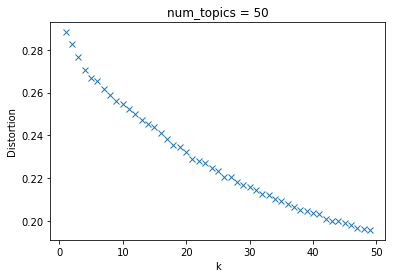

[(0, '0.199*"services" + 0.186*"care" + 0.162*"children" + 0.158*"health" + 0.153*"school" + 0.148*"community" + 0.143*"provide" + 0.140*"housing" + 0.131*"education" + 0.126*"programs"'), (1, '-0.504*"housing" + -0.363*"low" + -0.347*"income" + -0.234*"elderly" + 0.201*"school" + -0.169*"persons" + -0.162*"affordable" + 0.160*"students" + -0.143*"moderate" + -0.111*"hud"'), (2, '-0.373*"care" + 0.330*"school" + -0.300*"health" + 0.269*"students" + 0.211*"housing" + -0.209*"services" + 0.179*"low" + 0.170*"income" + -0.156*"medical" + -0.111*"home"'), (3, '0.377*"members" + -0.329*"school" + -0.252*"children" + -0.212*"care" + -0.184*"students" + 0.164*"club" + 0.148*"business" + 0.137*"promote" + 0.132*"industry" + 0.121*"union"'), (4, '0.285*"children" + 0.279*"youth" + -0.237*"health" + -0.213*"care" + -0.211*"students" + -0.176*"school" + 0.163*"families" + 0.145*"soccer" + 0.139*"disabilities" + -0.131*"medical"'), (5, '-0.381*"club" + -0.355*"members" + -0.244*"golf" + -0.201*"so

In [31]:
for num_topics in (3,5,10,20,50):
    model_23, corpus_23 = lsi_model(corpus, dictionary, num_topics)

In [33]:
five = [(0, '0.198*"services" + 0.184*"care" + 0.162*"children" + 0.157*"health" + 0.151*"school" + 0.149*"community" + 0.143*"provide" + 0.141*"housing" + 0.131*"education" + 0.126*"programs"'), (1, '-0.515*"housing" + -0.371*"low" + -0.355*"income" + -0.240*"elderly" + -0.172*"persons" + 0.167*"school" + -0.166*"affordable" + -0.146*"moderate" + 0.136*"students" + -0.114*"hud"'), (2, '-0.423*"care" + -0.306*"health" + 0.246*"school" + 0.225*"students" + -0.217*"services" + 0.187*"housing" + -0.160*"medical" + 0.155*"low" + 0.147*"income" + -0.127*"home"'), (3, '0.391*"members" + -0.362*"school" + -0.273*"children" + -0.201*"students" + 0.142*"club" + 0.140*"union" + 0.136*"business" + 0.132*"industry" + 0.123*"promote" + -0.119*"charter"'), (4, '-0.302*"see" + -0.297*"schedule" + 0.276*"club" + 0.242*"children" + 0.210*"members" + 0.200*"youth" + 0.174*"golf" + -0.172*"health" + 0.164*"social" + 0.151*"recreational"')]

In [35]:
for i in five:
    print(i)

(0, '0.198*"services" + 0.184*"care" + 0.162*"children" + 0.157*"health" + 0.151*"school" + 0.149*"community" + 0.143*"provide" + 0.141*"housing" + 0.131*"education" + 0.126*"programs"')
(1, '-0.515*"housing" + -0.371*"low" + -0.355*"income" + -0.240*"elderly" + -0.172*"persons" + 0.167*"school" + -0.166*"affordable" + -0.146*"moderate" + 0.136*"students" + -0.114*"hud"')
(2, '-0.423*"care" + -0.306*"health" + 0.246*"school" + 0.225*"students" + -0.217*"services" + 0.187*"housing" + -0.160*"medical" + 0.155*"low" + 0.147*"income" + -0.127*"home"')
(3, '0.391*"members" + -0.362*"school" + -0.273*"children" + -0.201*"students" + 0.142*"club" + 0.140*"union" + 0.136*"business" + 0.132*"industry" + 0.123*"promote" + -0.119*"charter"')
(4, '-0.302*"see" + -0.297*"schedule" + 0.276*"club" + 0.242*"children" + 0.210*"members" + 0.200*"youth" + 0.174*"golf" + -0.172*"health" + 0.164*"social" + 0.151*"recreational"')


In [36]:
three = [(0, '0.201*"services" + 0.188*"care" + 0.161*"children" + 0.161*"health" + 0.148*"community" + 0.148*"school" + 0.143*"provide" + 0.140*"housing" + 0.130*"education" + 0.125*"programs"'), (1, '-0.513*"housing" + -0.371*"low" + -0.355*"income" + -0.238*"elderly" + -0.171*"persons" + -0.165*"affordable" + 0.156*"school" + -0.145*"moderate" + 0.130*"students" + -0.113*"hud"'), (2, '-0.394*"care" + 0.323*"school" + -0.294*"health" + 0.261*"students" + -0.194*"services" + 0.186*"housing" + 0.157*"low" + -0.157*"medical" + 0.149*"income" + 0.136*"charter"')]

In [37]:
for i in three:
    print(i)

(0, '0.201*"services" + 0.188*"care" + 0.161*"children" + 0.161*"health" + 0.148*"community" + 0.148*"school" + 0.143*"provide" + 0.140*"housing" + 0.130*"education" + 0.125*"programs"')
(1, '-0.513*"housing" + -0.371*"low" + -0.355*"income" + -0.238*"elderly" + -0.171*"persons" + -0.165*"affordable" + 0.156*"school" + -0.145*"moderate" + 0.130*"students" + -0.113*"hud"')
(2, '-0.394*"care" + 0.323*"school" + -0.294*"health" + 0.261*"students" + -0.194*"services" + 0.186*"housing" + 0.157*"low" + -0.157*"medical" + 0.149*"income" + 0.136*"charter"')


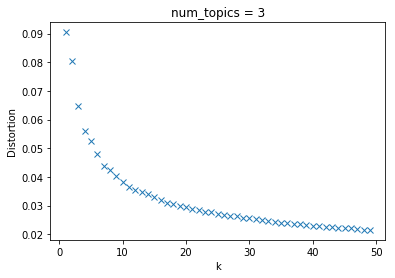

[(0, '0.201*"services" + 0.188*"care" + 0.161*"children" + 0.161*"health" + 0.148*"community" + 0.148*"school" + 0.143*"provide" + 0.140*"housing" + 0.130*"education" + 0.125*"programs"'), (1, '-0.513*"housing" + -0.371*"low" + -0.355*"income" + -0.238*"elderly" + -0.171*"persons" + -0.166*"affordable" + 0.157*"school" + -0.145*"moderate" + 0.130*"students" + -0.113*"hud"'), (2, '-0.394*"care" + 0.322*"school" + -0.294*"health" + 0.262*"students" + -0.194*"services" + 0.185*"housing" + 0.158*"low" + -0.157*"medical" + 0.149*"income" + 0.136*"charter"')]
(array([0, 1, 2, 3, 4, 5, 6], dtype=int32), array([ 3241, 30031,  1139,  4949, 19672,  5270, 13881]))


In [46]:
num_topics = 3
num_clusters = 7


m, c = lsi_model(corpus, dictionary, num_topics)
kmeans = KMeans(n_clusters = num_clusters, init = 'k-means++', random_state = 0).fit(c)
print(np.unique(kmeans.labels_, return_counts=True))
c = pd.DataFrame(c)
df['labels'] = kmeans.labels_
df = pd.concat([df.reset_index(drop = True), c], axis = 1)

In [47]:
df.head()

,ActivityOrMissionDesc,CYTotalExpensesAmt,CYTotalRevenueAmt,Desc,EIN,EmployeeCnt,FormType,GrossReceiptsAmt,LastUpdated,NetAssetsOrFundBalancesEOYAmt,...,TaxExemptBondsInd,TaxPeriod,URL,USAddress,WebsiteAddressTxt,text,labels,0,1,2
0,TO DEVELOP AFFORDABLE RENTAL AND OWNERSHIP HOU...,2880329.0,3413572.0,COMMUNITY SERVICES: WORKS WITH COMMUNITY MEMBE...,42964630,25.0,990,3419944.0,2017-01-11T22:15:15,2962890.0,...,0,201512,https://s3.amazonaws.com/irs-form-990/20161243...,{'ZIPCd': '02128'},WWW.NOAHCDC.ORG,TO DEVELOP AFFORDABLE RENTAL AND OWNERSHIP HOU...,6,0.195876,-0.027658,0.025769
1,"RELEAF MICHIGAN, INC. ASSISTS COMMUNITIES IN T...",71328.0,98045.0,TREES AND SEEDLINGS WERE PLANTED IN COOPERATIO...,382912028,1.0,990,133367.0,2017-01-11T22:15:15,9583.0,...,FALSE,201512,https://s3.amazonaws.com/irs-form-990/20161243...,{'ZIPCd': '48103'},RELEAFMICHIGAN.ORG,"RELEAF MICHIGAN, INC. ASSISTS COMMUNITIES IN T...",1,0.046911,0.006850,0.001023
2,SUPPORT FOR FAMILY AND FRIENDS OF MENTALLY ILL...,162576.0,184360.0,SUPPORT GROUP FOR FAMILY AND FRIENDS OF MENTAL...,202699020,3.0,990,222014.0,2017-01-11T22:15:15,163528.0,...,FALSE,201512,https://s3.amazonaws.com/irs-form-990/20161243...,{'ZIPCd': '62269'},WWW.KARLASMITHFOUNDATION.ORG,SUPPORT FOR FAMILY AND FRIENDS OF MENTALLY ILL...,1,0.082975,0.005509,-0.026488
3,Creation of a revolving loan fund.,806159.0,653283.0,Creation of a revolving loan fund for low inte...,251525572,0.0,990,653283.0,2017-01-11T22:15:15,1200323.0,...,0,201512,https://s3.amazonaws.com/irs-form-990/20161243...,{'ZIPCd': '16510'},www.developerie.com,Creation of a revolving loan fund. Creation of...,1,0.066224,-0.029602,0.037906
4,TO FACILITATE THE GRANT FUNDED BY THE NEW JERS...,564347.0,494830.0,GRANT - EMERGENCY MANAGEMENT THE OVERARCHING R...,810593280,0.0,990,494830.0,2017-01-11T22:15:15,135697.0,...,FALSE,201512,https://s3.amazonaws.com/irs-form-990/20161243...,{'ZIPCd': '08691'},WWW.HCANJ.ORG,TO FACILITATE THE GRANT FUNDED BY THE NEW JERS...,6,0.117246,0.008029,-0.057334


In [61]:
for cluster in range(7):
    print('\n', 'CLUSTER:', cluster, '\n')
    for i in range(5):
        print(df[df['labels'] == cluster]['text'].iloc[i], '\n')


 CLUSTER: 0 

OUR MISSION IS TO PROVIDE LOW-INCOME CHILDREN AND THEIR FAMILIES WITH A BEACON OF HOPE AND A SOURCE OF SUPPORT FOR A BRIGHTER FUTURE. WE STRIVE TO DO SO, BY PROVIDING HIGH QUALITY COMPREHENSIVE CHILD DEVELOPMENT SERVICES TO ENROLLED CHILDREN AND EMPOWERING FAMILIES TO ACHIEVE STABILITY IN THEIR HOME ENVIRONMENT. HEADSTART DAYCARE SERVICES 

CHRISTIAN MISSIONARY PROVIDE BASIC NEEDS FOOD, CLOTHING, EDUCATION, HOUSING FOR PEOPLE OF EL SALVADOR 

TO PLAN, CONSTRUCT, DEVELOP & MANAGE AFFORDABLE HOUSING FOR THE PUBLIC. TWIN PINES APARTMENTS, INC. WAS CREATED FOR THE PLANNING, CONSTRUCTING, DEVELOPING, AND MANAGING AFFORDABLE HOUSING FOR THE PUBLIC. THE PROJECT OPERATES A 56-UNIT APARTMENT COMPLEX IN REXBURG, IDAHO. 

TO PROVIDE SAFETY, ADVOCACY, OUTREACH AND FINANCIAL SUPPORT TO VICTIMS AT RISK OF DOMESTIC VIOLENCE. OUR SISTERS PLACE PROVIDED HOUSING, HOUSING ASSISTANCE, TRANSPORTATION, COUNCELING AND ANCILLARY SERVICES TO 53 VICTIMS OF DOMESTIC VIOLENCE AND 394 CRISIS CALLERS

TO DEVELOP AFFORDABLE RENTAL AND OWNERSHIP HOUSING FOR INDIVIDUALS, SENIORS AND FAMILIES. TO DEVELOP ENVIRONMENTAL JUSTICE AND CLIMATE CHANGE PROGRAMS, PROVIDE FORECLOSURE PREVENTION AND HOMEBUYER SERVICE COUNSELING PROGRAMS, AND WORK IN PARTNERSHIP WITH CITIES AND TOWNS EAST OF SPRINGFIELD. COMMUNITY SERVICES: WORKS WITH COMMUNITY MEMBERS FROM EAST BOSTON TO IMPROVE THE ENVIRONMENT, ENHANCE THE QUALITY OF LIFE AND DEVELOP LEADERSHIP SKILLS OF RESIDENTS OF EAST BOSTON AND BEYOND. THESE GOALS ARE ACHIEVED BY INVOLVING A BROAD RANGE OF RESIDENTS AND COMMUNITY ASSOCIATIONS IN THE PLANNING, DESIGN, IMPLEMENTATION, MAINTENANCE, AND PROGRAMMING OF ENVIRONMENTAL RESTORATION PROJECTS, AS WELL AS COMMUNITY ORGANIZING PROJECTS. ALSO PROVIDES ENGLISH CLASSES FOR SPEAKERS OF OTHER LANGUAGES (ESOL), AND SUMMER SOCCER AND SCHOOLYARD PROGRAMS FOR CHILDREN. 

TO FACILITATE THE GRANT FUNDED BY THE NEW JERSEY DEPARTMENT OF HEALTH AND SENIOR SERVICES FOR THE PREPAREDNESS AND RESPONSE TO BIOTERRORISM. GRA

In [ ]:
## Cluster 0: housing
## Cluster 1: ?
## Cluster 2: low-income housing
## Cluster 3: need n-grams... child care vs. health care
## Cluster 4: ?
## Cluster 5: schools, education
## Cluster 6: ?